In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#cd /content/drive/MyDrive/Speech2Text/

## Imports

In [ ]:
!pip install jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 40.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from jiwer import wer


In [ ]:
from IPython import display

## Getting Dataset

In [ ]:
!wget https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2

--2024-04-10 04:21:25--  https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2
Resolving data.keithito.com (data.keithito.com)... 24.199.73.137
Connecting to data.keithito.com (data.keithito.com)|24.199.73.137|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2748572632 (2.6G) [text/plain]
Saving to: ‘LJSpeech-1.1.tar.bz2’

LJSpeech-1.1.tar.bz 100%[===================>]   2.56G  12.8MB/s    in 3m 40s  

2024-04-10 04:25:06 (11.9 MB/s) - ‘LJSpeech-1.1.tar.bz2’ saved [2748572632/2748572632]



In [ ]:
!tar -xvjf LJSpeech-1.1.tar.bz2 >/dev/null

In [ ]:
data_url = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"

data_path = "/content/LJSpeech-1.1"

wav_path = data_path + "/wavs/"
metadata_path = data_path + "/metadata.csv"

In [ ]:
print(wav_path,metadata_path)

/content/LJSpeech-1.1/wavs/ /content/LJSpeech-1.1/metadata.csv


In [ ]:
metadata = pd.read_csv(metadata_path, sep = "|", header = None, quoting=3)
metadata.columns = ["file", "transcription", "normalized_transcription"]
metadata = metadata[["file", "normalized_transcription"]]
metadata['normalized_transcription'] = metadata['normalized_transcription'].astype(str)
metadata = metadata.sample(frac=1).reset_index(drop=True)
#metadata = metadata[3000:8000]
metadata.head()

,file,normalized_transcription
0,LJ048-0016,He likewise indicated he was disenchanted with...
1,LJ039-0051,In the absence of other evidence that Oswald a...
2,LJ037-0039,The man continued along tenth Street. Mrs. Mar...
3,LJ008-0260,One of the worst evils was the terrible and lo...
4,LJ032-0051,"On that date, Klein's placed an internal contr..."


In [ ]:
split = int(len(metadata) * 0.9)
dfT = metadata[:split]
dfV = metadata[split:]
print(f"Training set: {len(dfT)}")
print(f"Validation set: {len(dfV)}")

Training set: 11790
Validation set: 1310


## Parameters

In [ ]:
# Parameters
epochs = 1
frame_length = 256
frame_step = 160
ftt_length = 256

## Creating Vocabulary

In [ ]:
ch = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]
stoi = keras.layers.StringLookup(vocabulary=ch, oov_token="")
itos = keras.layers.StringLookup(vocabulary=stoi.get_vocabulary() , oov_token="", invert=True)

print("Vocabulary:", stoi.get_vocabulary())
print("Vocabulary size:", len(stoi.get_vocabulary()))

Vocabulary: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' ']
Vocabulary size: 31


In [ ]:
def encodeSimpleSample(wavFile, label):
    wav = tf.io.read_file(wav_path + wavFile + ".wav")
    wav, _ = tf.audio.decode_wav(wav)
    wav = tf.squeeze(wav, axis=-1)
    audio = tf.cast(wav, tf.float32)
    spectogram = tf.signal.stft(audio, frame_length=frame_length, frame_step=frame_step)

    spectogram = tf.abs(spectogram)
    spectogram = tf.math.pow(spectogram, 0.5)

    means = tf.math.reduce_mean(spectogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectogram, 1, keepdims=True)
    spectogram = (spectogram - means) / stddevs + 1e-9

    label = tf.strings.lower(label)
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    label = stoi(label)
    return spectogram, label


## Preparing Dataset

In [ ]:
metadata['normalized_transcription'] = metadata['normalized_transcription'].astype(str).str.lower()

In [ ]:
print(metadata["normalized_transcription"].dtype)
print(metadata["file"].dtype)
print(metadata["normalized_transcription"].head())

object
object
0    he likewise indicated he was disenchanted with...
1    in the absence of other evidence that oswald a...
2    the man continued along tenth street. mrs. mar...
3    one of the worst evils was the terrible and lo...
4    on that date, klein's placed an internal contr...
Name: normalized_transcription, dtype: object


In [ ]:
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((list(dfT["file"]),list(dfT["normalized_transcription"])))
train_dataset = train_dataset.map(encodeSimpleSample, num_parallel_calls=tf.data.AUTOTUNE,).padded_batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((list(dfV["file"]),list(dfV["normalized_transcription"])))
val_dataset = val_dataset.map(encodeSimpleSample, num_parallel_calls=tf.data.AUTOTUNE,).padded_batch(batch_size).prefetch(tf.data.AUTOTUNE)

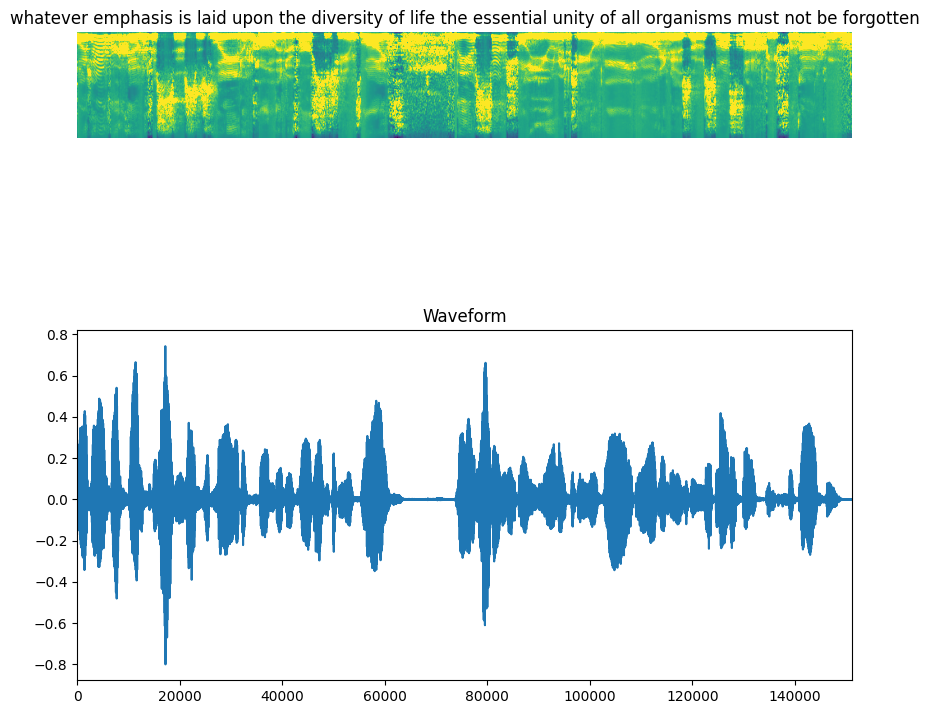

In [ ]:
fig  = plt.figure(figsize=(10, 10))
for batch in train_dataset.take(1):
    spectogram = batch[0][0].numpy()
    spectogram = np.array([np.trim_zeros(x) for x in np.transpose(spectogram)])
    label = batch[1][0]

    label = tf.strings.reduce_join(itos(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectogram, vmax = 1)
    ax.set_title(label)
    ax.axis("off")

    file = tf.io.read_file(wav_path + list(dfT["file"])[0] + ".wav")
    wav, _ = tf.audio.decode_wav(file)
    wav = wav.numpy()
    ax = plt.subplot(2, 1, 2)
    ax.plot(wav)
    ax.set_title("Waveform")
    ax.set_xlim(0, len(wav))

plt.show()

## Building Model

In [ ]:
@keras.saving.register_keras_serializable()
def CTC_loss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
def build_model(input_dim, output_dim, rnn_layers = 5, rnn_units = 128):
    input = layers.Input((None, input_dim), name = "input")
    x = layers.Reshape((-1, input_dim,1), name = "expand_dim")(input)
    x = layers.Conv2D(filters = 32, kernel_size = (11, 41), strides = [2, 2], padding = "same", use_bias = False,name = "conv1")(x)
    x = layers.BatchNormalization(name = "bn1")(x)
    x = layers.Conv2D(filters = 32, kernel_size = [11, 21], strides = [1, 2], padding = "same", use_bias = False, name = "conv2")(x)
    x = layers.BatchNormalization(name = "bn2")(x)
    x = layers.ReLU(name = "relu1")(x)
    x = layers.Reshape((-1, x.shape[-2]* x.shape[-1]))(x)

    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(units = rnn_units, activation = "tanh", recurrent_activation = "sigmoid", use_bias = True, return_sequences = True, reset_after = True, name = f"gru{i}")
        x = layers.Bidirectional(recurrent, name = f"bidirectional{i}", merge_mode = 'concat')(x)
        if i < rnn_layers:
            x = layers.Dropout(rate = 0.5)(x)

    x = layers.Dense(units = rnn_units*2, name = "dense1")(x)
    x = layers.ReLU(name = "relu2")(x)
    x = layers.Dropout(rate = 0.5)(x)
    output = layers.Dense(output_dim+1, activation = "softmax", name = "output")(x)
    model = keras.Model(inputs = input, outputs = output, name = "speech2text")
    opt = keras.optimizers.Adam(learning_rate = 1e-4)
    model.compile(optimizer = opt, loss = CTC_loss)
    return model


In [ ]:
model = build_model(input_dim = ftt_length // 2 + 1, output_dim = stoi.vocabulary_size(), rnn_units=512)
model.summary()

Model: "speech2text"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None, 129)]       0         
                                                                 
 expand_dim (Reshape)        (None, None, 129, 1)      0         
                                                                 
 conv1 (Conv2D)              (None, None, 65, 32)      14432     
                                                                 
 bn1 (BatchNormalization)    (None, None, 65, 32)      128       
                                                                 
 conv2 (Conv2D)              (None, None, 33, 32)      236544    
                                                                 
 bn2 (BatchNormalization)    (None, None, 33, 32)      128       
                                                                 
 relu1 (ReLU)                (None, None, 33, 32)      

In [ ]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length = input_len, greedy = True)[0][0]
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(itos(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

In [ ]:
class CallBackEval(keras.callbacks.Callback):
    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch:int, logs = None):
        prediction = []
        target = []
        for batch in self.dataset:
            x, y = batch
            batch_pred = model.predict(x)
            batch_pred = decode_batch_predictions(batch_pred)
            prediction.extend(batch_pred)
            for label in y:
                label = (tf.strings.reduce_join(itos(label)).numpy().decode("utf-8"))
                target.append(label)
        wer_score = wer(target, prediction)
        print(f"WER: {wer_score:.4f}")
        for i in np.random.randint(0, len(prediction), 2):
            print(f"Prediction: {prediction[i]}")
            print(f"Target: {target[i]}")
            print()

## Training Model

In [ ]:
validation_callback = CallBackEval(val_dataset)
history = model.fit(train_dataset, epochs = epochs, validation_data = val_dataset, callbacks = [validation_callback])


1/1 [==============================] - 1s 568ms/step
WER: 0.1016
Prediction: next to these cartons was the handmade paper bag previously discussed
Target: next to these cartons was the handmade paper bag previously discussed

Prediction: with convicts of all ages and characters to render it next to impossible but that with the obliteration of all sense of selfrespect
Target: with convicts of all ages and characters to render it next to impossible but that with the obliteration of all sense of selfrespect

369/369 [==============================] - 870s 2s/step - loss: 21.8628 - val_loss: 20.8737


## Inference

In [ ]:
# Inference
predictions = []
targets = []
for batch in val_dataset:
  X, y = batch
  batch_pred = model.predict(X)
  batch_pred = decode_batch_predictions(batch_pred)
  predictions.extend(batch_pred)

  for label in y:
      label = (tf.strings.reduce_join(itos(label)).numpy().decode("utf-8"))
      targets.append(label)
wer_score = wer(targets, predictions)
print(f"WER: {wer_score:.4f}")
for i in np.random.randint(0, len(predictions), 2):
    print(f"Prediction: {predictions[i]}")
    print(f"Target: {targets[i]}")
    print()

1/1 [==============================] - 0s 337ms/step
WER: 0.7910
Prediction: e was the unanimes and onewov the col testimmony of the pexprt whiceses befor the commision that theesus cartro caens wer fired fom the rvl
Target: it was the unanimous and unequivocal testimony of expert witnesses before the commission that these used cartridge cases were fired from the revolver

Prediction: at pentov the re as ir but  ther  the axpens habening rase pt the si
Target: at pentonville the rate was higher but there the expense had been increased by the site



In [ ]:
model.save("/content/drive/MyDrive/speech2text4.keras")

In [ ]:
model.save("my_model.keras")

## Reload Model

In [ ]:
model = keras.models.load_model("/content/drive/MyDrive/speech2text4.keras")

In [ ]:
validation_callback = CallBackEval(val_dataset)
history = model.fit(train_dataset, epochs = epochs, validation_data = val_dataset, callbacks = [validation_callback])

Epoch 1/2
1/1 [==============================] - 4s 4s/step
WER: 0.1188
Prediction: after he thought that what he had written in his book might be prof against him and he destroyed the book e
Target: after he thought that what he had written in his book might be proof against him and he destroyed it the book end quote

Prediction: each agent carried a thirtyeight caliber pisto and a shotgun and automat ic rifle were also available
Target: each agent carried a thirtyeightcaliber pistol and a shotgun and automatic rifle were also available

369/369 [==============================] - 1748s 5s/step - loss: 25.0525 - val_loss: 22.9626
Epoch 2/2
1/1 [==============================] - 1s 562ms/step
WER: 0.1075
Prediction: with exquisite torture and with a poison that would leave as he thought no trace
Target: with exquisite torture and with a poison that would leave as he thought no trace

Prediction: but no steps were taken to prevent any prisoner from obtaining more if he could pay for it
T

In [ ]:
def speechToText(audio_file_with_path):
    wav = tf.io.read_file(audio_file_with_path)
    wav, _ = tf.audio.decode_wav(wav)
    wav = tf.squeeze(wav, axis=-1)
    audio = tf.cast(wav, tf.float32)
    spectogram = tf.signal.stft(audio, frame_length=frame_length, frame_step=frame_step)

    spectogram = tf.abs(spectogram)
    spectogram = tf.math.pow(spectogram, 0.5)

    means = tf.math.reduce_mean(spectogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectogram, 1, keepdims=True)
    spectogram = (spectogram - means) / stddevs + 1e-9

    # label = tf.strings.lower(label)
    # label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    # label = stoi(label)
    #file = tf.io.read_file(audio_file)
    # wav, _ = tf.audio.decode_wav(file)
    batch_pred = model.predict(wav)
    return decode_batch_predictions(batch_pred)


In [ ]:
#transcript = speechToText("/content/LJ001-0003.wav")

In [ ]:
# Testing Reconstructed Model
#fig  = plt.figure(figsize=(10, 10))
for batch in train_dataset.take(5):
    spectogram = batch[0][0].numpy()
    label = batch[1][0]
    X = batch[0].numpy()
    label = tf.strings.reduce_join(itos(label)).numpy().decode("utf-8")
    #ax = plt.subplot(2, 1, 1)
    #ax.imshow(spectogram, vmax = 1)
    #ax.set_title(label)

    #ax.axis("off")

    file = tf.io.read_file(wav_path + list(dfT["file"])[0] + ".wav")
    wav, _ = tf.audio.decode_wav(file)
    batch_pred = model.predict(X)
    print("Label : ",label)
    print("Prediction : ",decode_batch_predictions(batch_pred)[0])
    print()

1/1 [==============================] - 1s 704ms/step
Label :  he likewise indicated he was disenchanted with russia
Prediction :  he likewise indicated he was disinchanted with russia

1/1 [==============================] - 1s 571ms/step
Label :  the necessary preliminaries took some time but the contracts for the new building were completed in eighteen fortynine when the works were commenced
Prediction :  the necessary preliminaries took some time but the contracts for the new building were completed in eighteen fortynine when the works were commenced

1/1 [==============================] - 1s 571ms/step
Label :  one of the aldermen moreover informed me that the whole court of aldermen were unanimous in their opinion on this subject
Prediction :  one of the aldermen moreover informed me that the whole court of aldermen were unanimous in their opinion on this subject

1/1 [==============================] - 1s 565ms/step
Label :  without waiting for any signal the platform dropped and h